In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sec_api import ExtractorApi
import requests
import re
from bs4 import BeautifulSoup
import time
import seaborn as sns

In [4]:
ko = yf.Ticker("KO")

In [5]:
fcf = ko.cash_flow.loc["Free Cash Flow"].iloc[0] # cashflow from yahoo finance
print(f"Yahoo Finance FCF: ${fcf/1e9:.2f}B")

Yahoo Finance FCF: $4.74B


In [6]:
headers = {
    "User-Agent": "you email @ domain.com",  # REQUIRED - use real info
    "Accept-Encoding": "gzip, deflate"
}
def get_financials(url):

    
    # Fetch with rate limit protection
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract all text
    full_text = soup.get_text(" ", strip=True)

    op_match = re.search(
        r"Net Cash Provided by Operating Activities.*?([\d,]+)\D+([\d,]+)\D+([\d,]+)", full_text.replace(",", ""))
    op_cash = [float(x) for x in op_match.groups()] if op_match else []
    
    # Find CapEx (3 years)
    capex_match = re.search(
    r"Purchases of property, plant and equipment\s*\(\s*\$?\s*([,\d]+)\s*\)\s*\(\s*\$?\s*([,\d]+)\s*\)\s*\(\s*\$?\s*([,\d]+)\s*\)",
    full_text)
    capex =  [abs(float(x.replace(',', ''))) for x in capex_match.groups()] if capex_match else []

    return {
        "operating_cash": op_cash,
        "capex": capex,
        "free_cash_flow": [o - c for o, c in zip(op_cash, capex)],
        "years": [2024, 2023, 2022]  # For reference
    }

        
doc_url = "https://www.sec.gov/Archives/edgar/data/21344/000002134425000011/ko-20241231.htm"  # Primary filing document
results = get_financials(doc_url)

print(f"""
OPERATING CASH FLOW CHECK:
2024: ${results['operating_cash'][0]/1e3:.1f}B (Expected ~$6.8B)
2023: ${results['operating_cash'][1]/1e3:.1f}B (Expected ~$11.6B)

CAPEX CHECK:
2024: ${results['capex'][0]/1e3:.1f}B (Expected ~$2.1B)
2023: ${results['capex'][1]/1e3:.1f}B (Expected ~$1.9B)
""")




OPERATING CASH FLOW CHECK:
2024: $6.8B (Expected ~$6.8B)
2023: $11.6B (Expected ~$11.6B)

CAPEX CHECK:
2024: $2.1B (Expected ~$2.1B)
2023: $1.9B (Expected ~$1.9B)



In [7]:
# Use extracted 2024 FCF (in $ millions)
latest_fcf = results['free_cash_flow'][0] 

# Project with 3% annual growth
growth_rate = 0.035
projected_fcf = [latest_fcf * (1 + growth_rate)**year for year in range(1, 6)]

print("Projected FCF (2025-2029):")
for i, val in enumerate(projected_fcf, 1):
    print(f"Year {i}: ${val/1e3:.2f}B")

Projected FCF (2025-2029):
Year 1: $4.91B
Year 2: $5.08B
Year 3: $5.26B
Year 4: $5.44B
Year 5: $5.63B


In [8]:
final_year_fcf = round(projected_fcf[4]/1e3,2)
long_term_growth = 0.035  # 3%
wacc = 0.06  # 6.4%

terminal_value = (final_year_fcf * (1 + long_term_growth)) / (wacc - long_term_growth) # formula of Terminal Value

print(f"Terminal Value: ${terminal_value:.2f}B")

Terminal Value: $233.08B


In [9]:
years = 5

pv_terminal_value = round(terminal_value,2) / (1 + wacc)**years
print(f"Present Value of Terminal Value: ${pv_terminal_value:.2f}B")

Present Value of Terminal Value: $174.17B


In [10]:
pv_terminal_value = round(pv_terminal_value,2)
pv_terminal_value

174.17

In [11]:
fcf = np.around(np.array(projected_fcf)/1e3,2) 
fcf

array([4.91, 5.08, 5.26, 5.44, 5.63])

In [12]:
fcf = np.around(np.array(projected_fcf)/1e3,2)  
discounted_fcf = fcf / (1 + wacc)**np.arange(1, 6)  # Discount each year

total_discounted_fcf = sum(discounted_fcf)

print(f"Total Discounted FCF (Years 1-5): ${total_discounted_fcf:.2f}B")


Total Discounted FCF (Years 1-5): $22.09B


In [13]:
enterprise_value = round(total_discounted_fcf,2) + round(pv_terminal_value,2)
print(enterprise_value,"B")

196.26 B


In [14]:
equity_value = 196.26 - 28.2  # In $B
print(f"Equity Value: ${equity_value}B")


Equity Value: $168.06B


In [15]:
share_price = 168.06 / 4.32 
print(f"Implied Share Price: ${share_price:.2f}")

Implied Share Price: $38.90


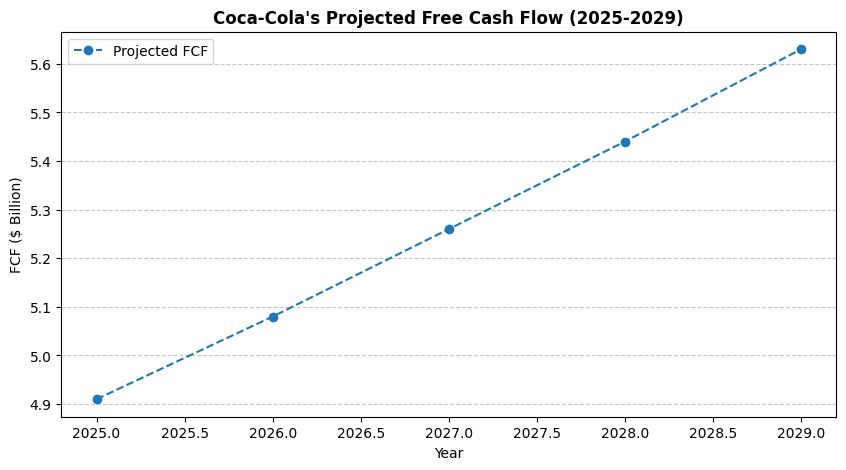

<Figure size 640x480 with 0 Axes>

In [16]:
years = [2025, 2026, 2027, 2028, 2029]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(years, fcf, marker='o', linestyle='--', color='#1f77b4', label='Projected FCF')
plt.title("Coca-Cola's Projected Free Cash Flow (2025-2029)", fontweight='bold')
plt.xlabel("Year")
plt.ylabel("FCF ($ Billion)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

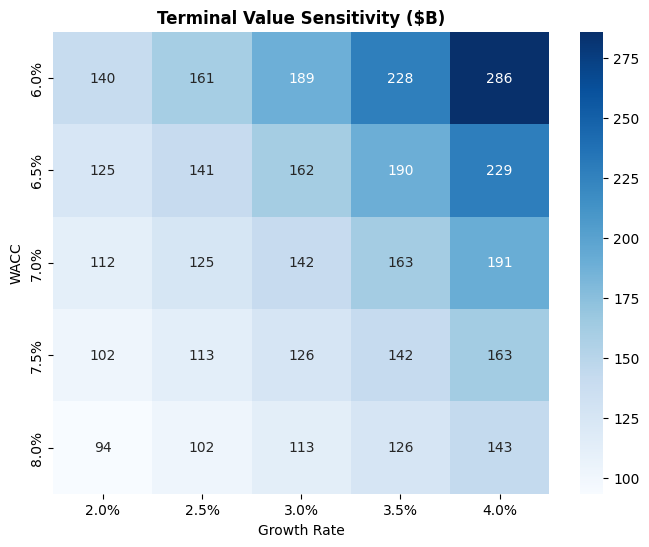

<Figure size 640x480 with 0 Axes>

In [17]:

# Create a grid of WACC and growth rates
wacc_range = np.linspace(0.06, 0.08, 5)  # WACC from 6% to 8%
growth_range = np.linspace(0.02, 0.04, 5)  # Growth from 2% to 4%

# Calculate TV for each combination
tv_grid = np.zeros((len(wacc_range), len(growth_range)))
for i, wacc in enumerate(wacc_range):
    for j, g in enumerate(growth_range):
        tv_grid[i][j] = (5.50 * (1 + g)) / (wacc - g)  # TV in $B

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(tv_grid, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=[f"{g:.1%}" for g in growth_range],
            yticklabels=[f"{w:.1%}" for w in wacc_range])
plt.title("Terminal Value Sensitivity ($B)", fontweight='bold')
plt.xlabel("Growth Rate")
plt.ylabel("WACC")
plt.show()

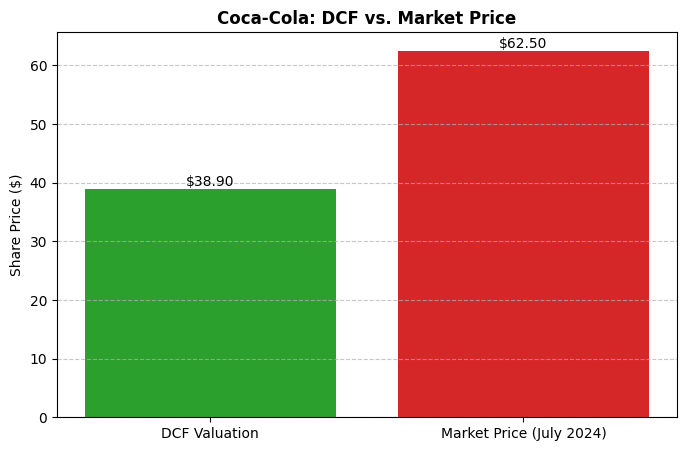

In [18]:
labels = ["DCF Valuation", "Market Price (July 2024)"]
values = [38.90, 62.50]  # Your share price vs. actual

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=['#2ca02c', '#d62728'])
plt.title("Coca-Cola: DCF vs. Market Price", fontweight='bold')
plt.ylabel("Share Price ($)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:.2f}', ha='center', va='bottom')